In [1]:
import googlemaps
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline

# Data Load

In [2]:
survey = pd.read_csv("Data Visualization Survey (Both sections) (Responses) - Form Responses 1.csv",
                     usecols=[5, 6, 16, 18], names=['age', 'location', 'hours', 'comfortability'], header=None)
survey.head()

,age,location,hours,comfortability
0,How old are you?,Where are you from?,How many hours a week do you expect to spend o...,How comfortable are you doing a presentation i...
1,23,...,0,1
2,26,China,2,4
3,28,Taiwan,4,3
4,29,Russia,4,4


# Cleaning

Remove first row since it seems unhelpful and not a lot of information

In [3]:
survey.drop(survey.index[0:2], inplace=True)

Standardize Location

In [4]:
survey = survey[(survey.location.notnull()) & (survey.location != ' ')]

locations = survey.location.unique()
locations

array(['China', 'Taiwan', 'Russia', 'china', 'Hong Kong', 'Chicago, IL',
       'Armenia', 'Brazil', 'Los Angeles', 'Shanghai, China', 'India',
       'San Diego, California', 'Colorado', 'Malaysia and Australia',
       'Canton, China', 'CA', 'Miami, FL', 'New York', 'Beijing',
       'England', 'Seattle', 'Massachusettes ', 'Sacramento, California',
       'Santa Barbara', 'San Francisco Bay Area', 'Tunisia', 'USA',
       'Peru', 'SF Bay Area', 'beijing, CHINA', 'Brooklyn',
       'San Francisco', 'Long Island', 'Denver, CO', 'Neverland',
       'Colombia', 'Houston', 'Miami', 'Livermore, CA', 'Barcelona',
       'sf bay area', 'New Orleans', 'California', 'Canada', 'Germany',
       'Bay Area', 'Virginia'], dtype=object)

Properly Geotag countries through Google API

In [5]:
with open('google_api.txt', 'r') as key:
    g_key = key.read().splitlines()[0]

googmaps = googlemaps.Client(key=g_key)

locs = []

for location in locations:
    locs.append(googmaps.geocode(location))

In [6]:
countries = []
for i, l in enumerate(locs):
    loc_type = l[0]['address_components'][0]['types']
    if 'country' in loc_type:
        name = l[0]['address_components'][0]['short_name']
    else:
        for j in range(5):
            try:
                name = l[0]['address_components'][j]['short_name']
            except:
                pass
    countries.append(name)
    print(i, locations[i], name)

0 China CN
1 Taiwan TW
2 Russia RU
3 china CN
4 Hong Kong HK
5 Chicago, IL US
6 Armenia AM
7 Brazil BR
8 Los Angeles US
9 Shanghai, China CN
10 India IN
11 San Diego, California US
12 Colorado US
13 Malaysia and Australia MY
14 Canton, China CN
15 CA US
16 Miami, FL US
17 New York US
18 Beijing CN
19 England GB
20 Seattle US
21 Massachusettes  US
22 Sacramento, California US
23 Santa Barbara US
24 San Francisco Bay Area US
25 Tunisia TN
26 USA US
27 Peru PE
28 SF Bay Area US
29 beijing, CHINA CN
30 Brooklyn US
31 San Francisco US
32 Long Island US
33 Denver, CO US
34 Neverland CA
35 Colombia CO
36 Houston US
37 Miami US
38 Livermore, CA US
39 Barcelona ES
40 sf bay area US
41 New Orleans US
42 California US
43 Canada CA
44 Germany DE
45 Bay Area US
46 Virginia US


In [7]:
location_dict = dict(zip(locations, countries))

def location_clean(row):
    if pd.notnull(row) and row != ' ':
        return location_dict[row]
    else:
        return row

survey['country_code'] = survey.location.apply(location_clean)

survey.head()

,age,location,hours,comfortability,country_code
2,26,China,2,4,CN
3,28,Taiwan,4,3,TW
4,29,Russia,4,4,RU
5,26,china,7,5,CN
6,16,Hong Kong,10,3,HK


## Create Age Groups

In [8]:
survey.age = survey.age.astype(int)
survey.hours = survey.hours.astype(float)
survey.comfortability = survey.comfortability.astype(int)

survey.loc[survey.age < 24, 'age_group'] = 'less than 24'
survey.loc[(survey.age >= 24) & (survey.age < 27), 'age_group'] = '24 to 26'
survey.loc[survey.age >= 27, 'age_group'] = 'greater than or equal to 27'

survey.head()

,age,location,hours,comfortability,country_code,age_group
2,26,China,2.0,4,CN,24 to 26
3,28,Taiwan,4.0,3,TW,greater than or equal to 27
4,29,Russia,4.0,4,RU,greater than or equal to 27
5,26,china,7.0,5,CN,24 to 26
6,16,Hong Kong,10.0,3,HK,less than 24


## Plot

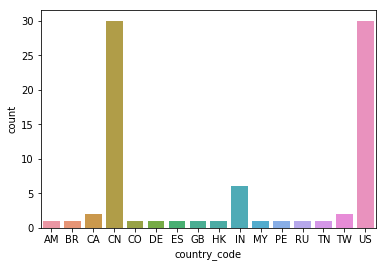

In [9]:
sns.countplot(x='country_code', data=survey,
              order=sorted(survey.country_code.unique()))

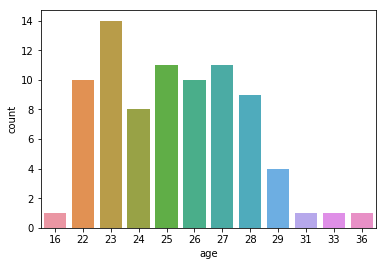

In [10]:
sns.countplot(x='age', data=survey)

In [11]:
low = survey[survey.age_group == 'less than 24']
med = survey[survey.age_group == '24 to 26']
high = survey[survey.age_group == 'greater than or equal to 27']

Make sure each age group is approximately the same

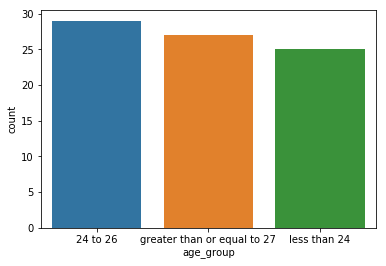

In [12]:
sns.countplot(x='age_group', data=survey)

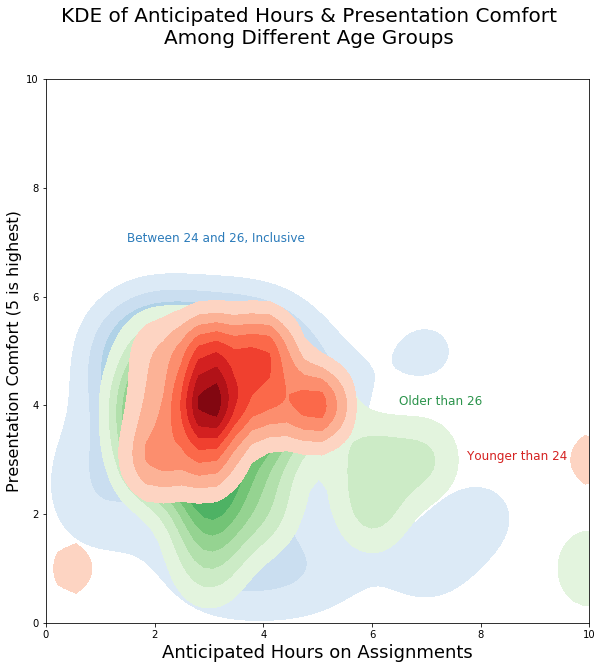

In [13]:
# Set up the figure
f, ax = plt.subplots(figsize=(10, 10))
ax.set_xlim(0, 10)
ax.set_ylim(0, 10)
ax.set_aspect("equal")

# Draw the three density plots
ax = sns.kdeplot(med.hours, med.comfortability,
                 cmap="Blues", shade=True, shade_lowest=False)
ax = sns.kdeplot(high.hours, high.comfortability,
                 cmap="Greens", shade=True, shade_lowest=False)
ax = sns.kdeplot(low.hours, low.comfortability,
                 cmap="Reds", shade=True, shade_lowest=False)

f.suptitle(
    'KDE of Anticipated Hours & Presentation Comfort\nAmong Different Age Groups', fontsize=20)
plt.xlabel('Anticipated Hours on Assignments', fontsize=18)
plt.ylabel('Presentation Comfort (5 is highest)', fontsize=16)

red = sns.color_palette("Reds")[-2]
blue = sns.color_palette("Blues")[-2]
green = sns.color_palette("Greens")[-2]
ax.text(7.75, 3.0, "Younger than 24", size=12, color=red)
ax.text(1.5, 7.0, "Between 24 and 26, Inclusive", size=12, color=blue)
ax.text(6.5, 4.0, "Older than 26", size=12, color=green)

f.savefig('hours_comfort_among_age.pdf')